In [1]:
import scanpy as sc
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import numpy as np
import pandas as pd

from scipy.stats import pearsonr

In [2]:
# raw data import
exp100=sc.read_10x_h5('../Data/sec_seq/GSE229042_filtered_feature_bc_matrix_100.h5',gex_only=False)
exp105=sc.read_10x_h5('../Data/sec_seq/GSE229042_filtered_feature_bc_matrix_105.h5',gex_only=False)
exp106=sc.read_10x_h5('../Data/sec_seq/GSE229042_filtered_feature_bc_matrix_106.h5',gex_only=False)

/Users/pablodigiusto/miniforge3/envs/secrecon2.0/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/pablodigiusto/miniforge3/envs/secrecon2.0/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/pablodigiusto/miniforge3/envs/secrecon2.0/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
exp100.var_names_make_unique()
exp105.var_names_make_unique()
exp106.var_names_make_unique()

## Pre-processing

In [10]:
# Exp100
sc.pp.filter_cells(exp100, min_genes=700) # Remove cells that have less than 700 genes expressed
# sc.pp.filter_genes(exp100, min_cells=3)
exp100.var['mt'] = exp100.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(exp100, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) # QC

In [11]:
# Exp105
sc.pp.filter_cells(exp105, min_genes=500)
# sc.pp.filter_genes(exp100, min_cells=3)
exp105.var['mt'] = exp105.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(exp105, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [12]:
# Exp106
sc.pp.filter_cells(exp106, min_genes=1000)
# sc.pp.filter_genes(exp100, min_cells=3)
exp106.var['mt'] = exp106.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(exp106, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [13]:
exp100 = exp100[exp100.obs.total_counts < 50000, :]
exp100 = exp100[exp100.obs.pct_counts_mt < 10, :]
exp105 = exp105[exp105.obs.total_counts < 35000, :]
exp105 = exp105[exp105.obs.pct_counts_mt < 2.5, :]
exp106 = exp106[exp106.obs.total_counts < 50000, :]
exp106 = exp106[exp106.obs.pct_counts_mt < 5, :]

In [14]:
# filter cells with <2000 or <350 ADT barcodes
## (as noted by authors,#exp105 has other cell surface tag, IgG_ADT compromised, lower then exp100 and exp106)
exp100 = exp100[(exp100.obs_vector('IgG_ADT') <2000), :]
exp106 = exp106[(exp106.obs_vector('IgG_ADT') <2000), :]
exp105 = exp105[(exp105.obs_vector('IgG_ADT') <350), :]

In [15]:
# Concatenate raw counts from three donors into `data`
data = exp100.concatenate(exp105, exp106, batch_key='sample')

/Users/pablodigiusto/miniforge3/envs/secrecon2.0/lib/python3.9/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [16]:
# 1) Subset out your RNA object
rna = data[:, data.var["feature_types"] == "Gene Expression"].copy()

# 2) Then extract the ADT (antibody) feature from the full data
adt = data[:, data.var['feature_types'] == 'Antibody Capture'].copy()

if adt.shape[1] == 1:
    X = adt.X.toarray() if hasattr(adt.X, "toarray") else adt.X
    ab_counts = X.ravel()
    # now you can safely write into rna.obs
    rna.obs['IgG_ADT_counts'] = ab_counts
else:
    arr = adt.X.toarray() if hasattr(adt.X, "toarray") else np.asarray(adt.X)
    rna.obs['total_ADT_counts'] = arr.sum(axis=1)


In [17]:
data[:, data.var['feature_types'] == 'Antibody Capture']

View of AnnData object with n_obs × n_vars = 14322 × 1
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2'

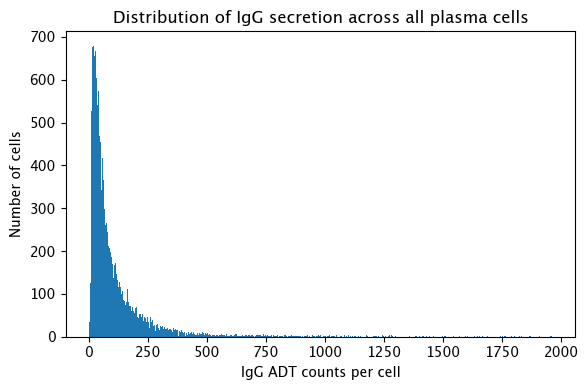

In [18]:
# pull out the counts
counts = rna.obs['IgG_ADT_counts']

# make the figure
plt.figure(figsize=(6,4))
plt.hist(counts, bins=500)
plt.xlabel('IgG ADT counts per cell')
plt.ylabel('Number of cells')
plt.title('Distribution of IgG secretion across all plasma cells')
plt.tight_layout()
plt.show()

## Calculating Per-Cell IgG Productivity from ADT Counts

This cell computes each cell’s IgG productivity (mass produced per time) in two ways:

1. **Concentration calculation**  
   - Convert ADT UMI counts to molecules using \(N_{\rm tags}\).  
   - Convert to molar concentration using Avogadro’s number \(N_A\) and capture volume \(V_L\).  
   - Convert to mass concentration (g/L) via the IgG molecular weight (MW), then to μg/mL.

2. **Productivity calculation**  
   - Compute mass of IgG captured per cell (\(m_{\rm cell}\)) from concentration and \(V_L\).  
   - Divide by incubation time (30 min = 0.5 h) to get:  
     - μg IgG per cell per hour  
     - pg IgG per cell per minute  

**Assumptions & parameters**  
- Capture volume \(V_L\) = 11 pL  
- One UMI tags one IgG molecule (\(N_{\rm tags}=1\))  
- IgG MW ≃150 kDa  
- Incubation time = 30 min

In [22]:
# ─── Constants & parameters ────────────────────────────────────────────────
N_A           = 6.022e23     # Avogadro’s number (molecules/mol)
V_L           = 11e-12       # capture volume per cell (L)
N_tags        = 1            # UMI tags per IgG molecule
MW            = 150e3        # IgG molecular weight (g/mol)
incubation_min = 30          # incubation time (min)
incubation_h   = incubation_min / 60  # incubation time (h)

# ─── Pull out ADT counts & compute concentration ──────────────────────────
counts      = rna.obs['IgG_ADT_counts'].values
molecules   = counts / N_tags
conc_M      = molecules / (N_A * V_L)        # mol/L
conc_g_L    = conc_M * MW                    # g/L
conc_ug_ml  = conc_g_L * 1e3                 # μg/mL

# ─── Store concentration in AnnData ──────────────────────────────────────
rna.obs['IgG_conc_M']   = conc_M
rna.obs['IgG_conc_pM']  = conc_M * 1e12      # pM
rna.obs['IgG_ug_ml']    = conc_ug_ml         # μg/mL

# ─── Compute per-cell productivity ────────────────────────────────────────
mass_cell_ug         = conc_ug_ml * 1e3 * V_L      # μg per cell
prod_ug_per_cell_h   = mass_cell_ug / incubation_h
prod_pg_per_cell_min = (mass_cell_ug * 1e3) / incubation_min

# ─── Store productivity in AnnData ──────────────────────────────────────
rna.obs['IgG_prod_ug_per_cell_h']   = prod_ug_per_cell_h
rna.obs['IgG_prod_pg_per_cell_min'] = prod_pg_per_cell_min

# ─── Summarize results ───────────────────────────────────────────────────
summary = pd.DataFrame({
    'ADT_counts':             counts,
    'conc_pM':                rna.obs['IgG_conc_pM'],
    'conc_ug_ml':             rna.obs['IgG_ug_ml'],
    'ug_per_cell_per_h':      prod_ug_per_cell_h,
    'pg_per_cell_per_min':    prod_pg_per_cell_min
})
print(summary.describe())

         ADT_counts       conc_pM    conc_ug_ml  ug_per_cell_per_h  \
count  14322.000000  14322.000000  14322.000000       1.432200e+04   
mean     112.422707     16.971514      0.002546       5.600600e-11   
std      166.452469     25.127991      0.003769       8.292197e-11   
min        0.000000      0.000000      0.000000       0.000000e+00   
25%       31.000000      4.679811      0.000702       1.544337e-11   
50%       59.000000      8.906735      0.001336       2.939223e-11   
75%      126.000000     19.021164      0.002853       6.276984e-11   
max     1962.000000    296.186707      0.044428       9.774163e-10   

       pg_per_cell_per_min  
count         1.432200e+04  
mean          9.334333e-10  
std           1.382031e-09  
min           0.000000e+00  
25%           2.573896e-10  
50%           4.898705e-10  
75%           1.046164e-09  
max           1.629027e-08  


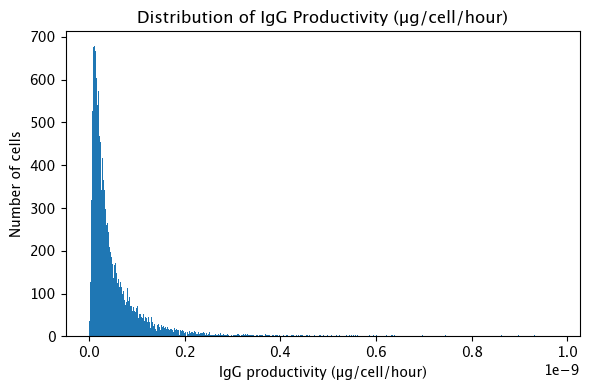

In [26]:
# —— Plot μg/cell/hour —— #

prod_ug_h   = rna.obs['IgG_prod_ug_per_cell_h'].values
plt.figure(figsize=(6,4))
plt.hist(prod_ug_h, bins=500)
plt.xlabel('IgG productivity (μg/cell/hour)')
plt.ylabel('Number of cells')
plt.title('Distribution of IgG Productivity (μg/cell/hour)')
plt.tight_layout()
plt.show()